In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np

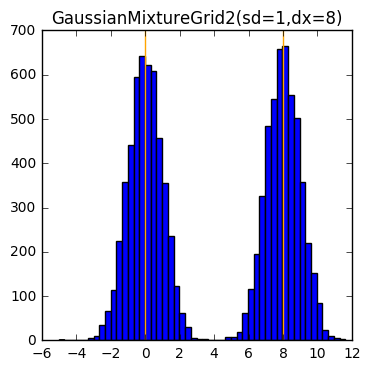

In [2]:
gr1d = GaussianMixtureGrid(2, 1, 8, 1)
plt.figure(figsize=(4,4))
plt.title(gr1d.name)
plt.hist(gr1d.sample(10000), bins=50)
for mu in gr1d.means:
  plt.axvline(mu, c='orange')
plt.show()

In [153]:
s = gr1d.sample(20000)[:,0]

In [154]:
s2 = gr1d.sample(20000)[:,0]

In [122]:
def converged(s, tol=1e-2):
  return np.abs(np.mean(s) - gr1d.means.mean()) < tol

In [155]:
print(converged(s, tol=1e-1))
print(converged(s, tol=1e-3))

True
False


In [201]:
def convergence_time(s, tol=1e-2, res=100):
  if type(s)==np.ndarray and len(s.shape)==1:
    s = np.array([s])
  i = res
  conv_count = 0
  fail_count = 0
  while i <= len(s[0]):
    if converged(np.vstack(tuple(ss[:i] for ss in s)), tol):
      conv_count += 1
    else:
      fail_count += 1
    if fail_count > 5:
      fail_count = 0
      conv_count = 0
    elif conv_count > 20:
      return i
    i += res
  return -1

In [202]:
print(convergence_time(s, tol=1e-1))
print(convergence_time(s, tol=5e-2))

2500
15100


In [203]:
convergence_time(np.array([s,s2]), tol=5e-2)

10900

In [8]:
import pymc3 as pm

with pm.Model() as model:
  mix = gr1d.to_pymc()
  trace1 = pm.sample(100000, init=None)

Assigned NUTS to GaussianMixtureGrid2(sd=1,dx=8)
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '74987' (I am process '75227')
100%|██████████| 100000/100000 [00:39<00:00, 2537.77it/s]


In [163]:
values = trace1[gr1d.name]

In [166]:
converged(values, tol=5e-2)

False

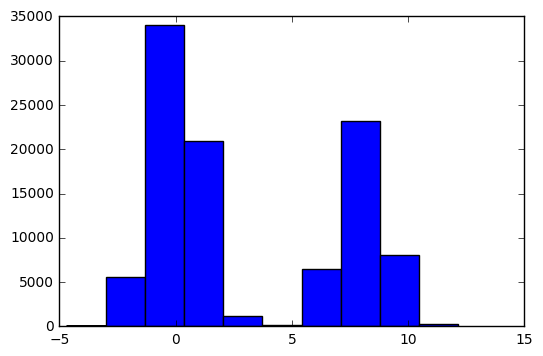

In [167]:
plt.hist(values)
plt.show()

In [61]:
convergence_time(values, tol=0.1)

-1

In [62]:
s2 = gr1d.rejection_sample_bounding_box(50000)

In [66]:
len(s2)

17755

In [64]:
convergence_time(s2, tol=0.1)

5900

In [47]:
s3 = gr1d.mh_with_teleportation(
                                initial_value=np.array([4]),
                                proposal=lambda x: np.random.multivariate_normal(x, np.identity(1)*gr1d.stddev),
num_samples=25000,
teleprob=0.1)

In [65]:
convergence_time(s3, tol=0.1)

8900

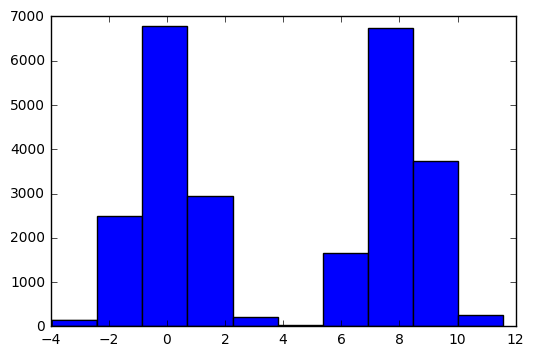

In [51]:
plt.hist(s3)
plt.show()

In [179]:
direct_samples = np.array([gr1d.sample(20000)[:,0] for _ in range(16)])

In [169]:
rej_sampls = [gr1d.rejection_sample_bounding_box(100000) for _ in range(16)]

In [183]:
direct_samples.shape

(16, 20000)

In [196]:
convergence_time(direct_samples)

4400

In [204]:
convergence_time(rej_sampls)

29700